In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import time
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.autograd import Variable

# Reading data

In [2]:
def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

    return train_data, train_label, test_data, test_label

# Define EEGNet

In [3]:
class EEGNet(nn.Module):
    def __init__(self, eps=1e-05, momentum=0.1, drop=0.25, act='ELU'):
        super().__init__()
        self.act = nn.ELU()
        if self.act == 'ReLU':
            self.act = nn.ReLU()
        elif self.act == 'LeakyReLU':
            self.act == nn.LeakyReLU()
            
        self.drop = nn.Dropout(p=drop)
        
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 21), stride=(1, 1), padding=(0, 10), bias=False),
            nn.BatchNorm2d(16, eps=eps, momentum=momentum, affine=True, track_running_stats=True)
        )
        
        self.depthwisecConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False),
            nn.BatchNorm2d(32, eps=eps, momentum=momentum, affine=True, track_running_stats=True),
            self.act,
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            self.drop
        )
        
        self.seperableConv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(1, 11), stride=(1, 1), padding=(0, 5), bias=False),
            nn.BatchNorm2d(64, eps=eps, momentum=momentum, affine=True, track_running_stats=True),
            self.act,
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            self.drop
        )
        
        self.classify = nn.Sequential(
            nn.Linear(in_features=23*64, out_features=2, bias=True)
        )
        
    def forward(self, x):
        x = self.firstconv(x) 
        x = self.depthwisecConv(x)  
        x = self.seperableConv(x)
        x = x.view(x.size(0), -1)
        x = self.classify(x)
        return x    

# Define DeepConvNet

In [4]:
class DeepConvNet(nn.Module):
    def __init__(self, eps=1e-05, momentum=0.1, drop=0.25, act='ELU'):
        super().__init__()
        self.act = nn.ELU()
        if self.act == 'ReLU':
            self.act = nn.ReLU()
        elif self.act == 'LeakyReLU':
            self.act == nn.LeakyReLU()
            
        self.drop = nn.Dropout(p=drop)
        self.pool = nn.MaxPool2d(kernel_size=(1, 2))
        
        self.firstConv = nn.Sequential(
            #nn.view(1,2,750)
            nn.Conv2d(1, 25, kernel_size=(1, 19), padding=(0, 9), bias=False),
            nn.Conv2d(25, 25, kernel_size=(2, 1), bias=False),
            nn.BatchNorm2d(25, eps=eps, momentum=momentum, affine=True, track_running_stats=True),
            self.act,
            self.pool,
            self.drop
        )
        
        self.secondConv = nn.Sequential(
            nn.Conv2d(25, 50, kernel_size=(1, 19), padding=(0, 9), bias=False),
            nn.BatchNorm2d(50, eps=eps, momentum=momentum, affine=True, track_running_stats=True),
            self.act,
            self.pool,
            self.drop
        )
        
        self.thirdConv = nn.Sequential(
            nn.Conv2d(50, 100, kernel_size=(1, 17), padding=(0, 8), bias=False),
            nn.BatchNorm2d(100, eps=eps, momentum=momentum, affine=True, track_running_stats=True),
            self.act,
            self.pool,
            self.drop
        )
        
        self.fourthConv = nn.Sequential(
            nn.Conv2d(100, 200, kernel_size=(1, 15), padding=(0, 7), bias=False),
            nn.BatchNorm2d(200, eps=eps, momentum=momentum, affine=True, track_running_stats=True),
            self.act,
            self.pool,
            self.drop
        )
        
        self.classify = nn.Sequential(
            nn.Linear(in_features=200*46, out_features=2, bias=True)
        )
    def forward(self, x):
        x = self.firstConv(x) 
        x = self.secondConv(x)  
        x = self.thirdConv(x)
        x = self.fourthConv(x)
        x = x.view(x.size(0), -1)
        x = self.classify(x)
        return x

# Define hyper-parameter

In [5]:
batch_size = 300
epochs = 500
lr = 1e-3
lr_decay = 1

# Define path, training environment

In [6]:
eeg_elu_dir = "EEG/ELU"
eeg_relu_dir = "EEG/ReLU"
eeg_leaky_dir = "EEG/LeakyReLU"

deep_elu_dir = "DeepConvNet/ELU"
deep_relu_dir = "DeepConvNet/ReLU"
deep_leaky_dir = "DeepConvNet/LeakyReLU"


eeg_elu_model_dir = os.path.join("models", eeg_elu_dir)
if not os.path.exists(eeg_elu_model_dir):
    os.makedirs(eeg_elu_model_dir)
eeg_relu_model_dir = os.path.join("models", eeg_relu_dir)
if not os.path.exists(eeg_relu_model_dir):
    os.makedirs(eeg_relu_model_dir)
eeg_leaky_model_dir = os.path.join("models", eeg_leaky_dir)
if not os.path.exists(eeg_leaky_model_dir):
    os.makedirs(eeg_leaky_model_dir)
    
deep_elu_model_dir = os.path.join("models", deep_elu_dir)
if not os.path.exists(deep_elu_model_dir):
    os.makedirs(deep_elu_model_dir)
deep_relu_model_dir = os.path.join("models", deep_relu_dir)
if not os.path.exists(deep_relu_model_dir):
    os.makedirs(deep_relu_model_dir)
deep_leaky_model_dir = os.path.join("models", deep_leaky_dir)
if not os.path.exists(deep_leaky_model_dir):
    os.makedirs(deep_leaky_model_dir)


use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

eeg_elu_model = EEGNet()
eeg_relu_model = EEGNet(act='ReLU')
eeg_leaky_model = EEGNet(act='LeakyReLU')

deep_elu_model = DeepConvNet()
deep_relu_model = DeepConvNet(act='ReLU')
deep_leaky_model = DeepConvNet(act='LeakyReLU')


if use_gpu:
    eeg_elu_model = nn.DataParallel(eeg_elu_model.cuda(), device_ids=num_gpu)
    eeg_relu_model = nn.DataParallel(eeg_relu_model.cuda(), device_ids=num_gpu)
    eeg_leaky_model = nn.DataParallel(eeg_leaky_model.cuda(), device_ids=num_gpu)
    
    deep_elu_model = nn.DataParallel(deep_elu_model.cuda(), device_ids=num_gpu)
    deep_relu_model = nn.DataParallel(deep_relu_model.cuda(), device_ids=num_gpu)
    deep_leaky_model = nn.DataParallel(deep_leaky_model.cuda(), device_ids=num_gpu)
    
models = []
models.append([eeg_elu_model, eeg_elu_dir])
models.append([eeg_relu_model, eeg_relu_dir])
models.append([eeg_leaky_model, eeg_leaky_dir])
models.append([deep_elu_model, deep_elu_dir])
models.append([deep_relu_model, deep_relu_dir])
models.append([deep_leaky_model, deep_leaky_dir])

# Visualize model

In [7]:
print(eeg_elu_model)
print(deep_elu_model)

DataParallel(
  (module): EEGNet(
    (act): ELU(alpha=1.0)
    (drop): Dropout(p=0.25)
    (firstconv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(1, 21), stride=(1, 1), padding=(0, 10), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (depthwisecConv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
      (4): Dropout(p=0.25)
    )
    (seperableConv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 11), stride=(1, 1), padding=(0, 5), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
      (4): Dropout(p=0.25)
    )
    (classify): Seque

# Read Data and define optimizer

In [8]:
train_data, train_label, test_data, test_label = read_bci_data()
train_data = torch.tensor(train_data).float()
train_label = torch.tensor(train_label).long()
test_data = torch.tensor(test_data).float()
test_label = torch.tensor(test_label).long()

train_dataset = TensorDataset(train_data, train_label)
test_dataset = TensorDataset(test_data, test_label)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

#define loss func.
loss_func = torch.nn.CrossEntropyLoss()

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


# Train

In [9]:
def train(model_dir, model):
    train_accuracy = []
    test_accuracy = []
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        if epoch > 0 and epoch%100==0:
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] * lr_decay
        accurate = 0
        total = 0
        optimizer.zero_grad()
        model.train()
        Net = "EEG" if "EEG" in model_dir else "DeepConv"
        Act = "ELU"
        if "relu" in model_dir:
            Act = "ReLU"
        elif "leaky" in model_dir:
            Act = "Leaky"
        configs = "{}_{}_epoch_{}".format(Net, Act, epoch)
        model_path = os.path.join(model_dir, configs)
        
        ts = time.time()
        for iter, batch in enumerate(train_loader):
            
            if use_gpu:
                inputs = Variable(batch[0].cuda())
                labels = Variable(batch[1].cuda())
            else:
                inputs = Variable(batch[0])
                labels = Variable(batch[1])
                                
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            
            for index, output in enumerate(outputs):
                if torch.argmax(output).item() == labels[index].item():
                    accurate += 1
                total += 1
        train_accuracy.append(100*accurate/total)
        print("Finish epoch {}, Accuracy {}%".format(epoch, train_accuracy[-1]))
        test_accuracy.append(prediction(model))
    return train_accuracy, test_accuracy

# Test

In [10]:
def prediction(model):
    accurate = 0
    total = 0
    for iter, batch in enumerate(test_loader):
            
        if use_gpu:
            inputs = Variable(batch[0].cuda())
            labels = Variable(batch[1].cuda())
        else:
            inputs = Variable(batch[0])
            labels = Variable(batch[1])
                                
        outputs = model(inputs)
        for index, output in enumerate(outputs):
            if torch.argmax(output).item() == labels[index].item():
                accurate += 1
            total += 1
    accuracy = 100*accurate/total
    print("Test Accuracy {}%".format(accuracy))
    return accuracy

In [11]:
train_accs = []
test_accs = []
for index, model in enumerate(models):
    #if index < 3:
    #    continue
    print("start training {}".format(model[1]))
    train_acc, test_acc = train(model[1], model[0])
    train_accs.append(train_acc)
    test_accs.append(test_acc)

start training EEG/ELU
Finish epoch 0, Accuracy 55.0%
Test Accuracy 64.53703703703704%
Finish epoch 1, Accuracy 68.24074074074075%
Test Accuracy 67.31481481481481%
Finish epoch 2, Accuracy 72.77777777777777%
Test Accuracy 70.0925925925926%
Finish epoch 3, Accuracy 73.14814814814815%
Test Accuracy 70.74074074074075%
Finish epoch 4, Accuracy 73.24074074074075%
Test Accuracy 70.46296296296296%
Finish epoch 5, Accuracy 74.07407407407408%
Test Accuracy 71.01851851851852%
Finish epoch 6, Accuracy 74.35185185185185%
Test Accuracy 70.0925925925926%
Finish epoch 7, Accuracy 74.53703703703704%
Test Accuracy 70.18518518518519%
Finish epoch 8, Accuracy 75.0%
Test Accuracy 70.27777777777777%
Finish epoch 9, Accuracy 75.27777777777777%
Test Accuracy 69.72222222222223%
Finish epoch 10, Accuracy 74.72222222222223%
Test Accuracy 70.27777777777777%
Finish epoch 11, Accuracy 75.0925925925926%
Test Accuracy 71.20370370370371%
Finish epoch 12, Accuracy 75.64814814814815%
Test Accuracy 71.94444444444444%
Fi

Finish epoch 107, Accuracy 89.07407407407408%
Test Accuracy 76.57407407407408%
Finish epoch 108, Accuracy 90.18518518518519%
Test Accuracy 77.5925925925926%
Finish epoch 109, Accuracy 88.61111111111111%
Test Accuracy 78.79629629629629%
Finish epoch 110, Accuracy 89.44444444444444%
Test Accuracy 77.22222222222223%
Finish epoch 111, Accuracy 89.62962962962963%
Test Accuracy 77.5925925925926%
Finish epoch 112, Accuracy 91.01851851851852%
Test Accuracy 77.5%
Finish epoch 113, Accuracy 90.74074074074075%
Test Accuracy 78.24074074074075%
Finish epoch 114, Accuracy 90.0%
Test Accuracy 78.24074074074075%
Finish epoch 115, Accuracy 91.57407407407408%
Test Accuracy 77.87037037037037%
Finish epoch 116, Accuracy 90.46296296296296%
Test Accuracy 78.79629629629629%
Finish epoch 117, Accuracy 91.38888888888889%
Test Accuracy 76.66666666666667%
Finish epoch 118, Accuracy 90.0925925925926%
Test Accuracy 79.16666666666667%
Finish epoch 119, Accuracy 90.55555555555556%
Test Accuracy 80.0925925925926%
Fin

Finish epoch 214, Accuracy 96.01851851851852%
Test Accuracy 80.0%
Finish epoch 215, Accuracy 95.37037037037037%
Test Accuracy 77.87037037037037%
Finish epoch 216, Accuracy 95.55555555555556%
Test Accuracy 77.31481481481481%
Finish epoch 217, Accuracy 95.0925925925926%
Test Accuracy 79.07407407407408%
Finish epoch 218, Accuracy 95.55555555555556%
Test Accuracy 79.25925925925925%
Finish epoch 219, Accuracy 95.74074074074075%
Test Accuracy 78.24074074074075%
Finish epoch 220, Accuracy 94.25925925925925%
Test Accuracy 80.27777777777777%
Finish epoch 221, Accuracy 95.74074074074075%
Test Accuracy 78.79629629629629%
Finish epoch 222, Accuracy 95.18518518518519%
Test Accuracy 77.77777777777777%
Finish epoch 223, Accuracy 96.20370370370371%
Test Accuracy 76.29629629629629%
Finish epoch 224, Accuracy 94.35185185185185%
Test Accuracy 78.33333333333333%
Finish epoch 225, Accuracy 95.18518518518519%
Test Accuracy 79.72222222222223%
Finish epoch 226, Accuracy 94.25925925925925%
Test Accuracy 78.055

Finish epoch 320, Accuracy 98.51851851851852%
Test Accuracy 78.61111111111111%
Finish epoch 321, Accuracy 98.05555555555556%
Test Accuracy 80.0925925925926%
Finish epoch 322, Accuracy 98.24074074074075%
Test Accuracy 79.81481481481481%
Finish epoch 323, Accuracy 97.77777777777777%
Test Accuracy 80.0925925925926%
Finish epoch 324, Accuracy 98.33333333333333%
Test Accuracy 78.70370370370371%
Finish epoch 325, Accuracy 98.14814814814815%
Test Accuracy 79.35185185185185%
Finish epoch 326, Accuracy 98.33333333333333%
Test Accuracy 78.61111111111111%
Finish epoch 327, Accuracy 98.05555555555556%
Test Accuracy 80.46296296296296%
Finish epoch 328, Accuracy 98.33333333333333%
Test Accuracy 81.48148148148148%
Finish epoch 329, Accuracy 97.77777777777777%
Test Accuracy 79.9074074074074%
Finish epoch 330, Accuracy 97.22222222222223%
Test Accuracy 80.55555555555556%
Finish epoch 331, Accuracy 98.33333333333333%
Test Accuracy 80.27777777777777%
Finish epoch 332, Accuracy 98.33333333333333%
Test Accu

Finish epoch 425, Accuracy 99.25925925925925%
Test Accuracy 79.44444444444444%
Finish epoch 426, Accuracy 98.70370370370371%
Test Accuracy 77.77777777777777%
Finish epoch 427, Accuracy 98.88888888888889%
Test Accuracy 80.27777777777777%
Finish epoch 428, Accuracy 99.07407407407408%
Test Accuracy 80.18518518518519%
Finish epoch 429, Accuracy 99.44444444444444%
Test Accuracy 79.81481481481481%
Finish epoch 430, Accuracy 98.79629629629629%
Test Accuracy 80.37037037037037%
Finish epoch 431, Accuracy 99.16666666666667%
Test Accuracy 80.46296296296296%
Finish epoch 432, Accuracy 99.53703703703704%
Test Accuracy 80.0925925925926%
Finish epoch 433, Accuracy 99.16666666666667%
Test Accuracy 79.53703703703704%
Finish epoch 434, Accuracy 98.24074074074075%
Test Accuracy 79.53703703703704%
Finish epoch 435, Accuracy 98.88888888888889%
Test Accuracy 79.9074074074074%
Finish epoch 436, Accuracy 98.33333333333333%
Test Accuracy 79.72222222222223%
Finish epoch 437, Accuracy 99.53703703703704%
Test Acc

Finish epoch 30, Accuracy 81.48148148148148%
Test Accuracy 74.62962962962963%
Finish epoch 31, Accuracy 83.33333333333333%
Test Accuracy 74.16666666666667%
Finish epoch 32, Accuracy 83.61111111111111%
Test Accuracy 74.16666666666667%
Finish epoch 33, Accuracy 82.12962962962963%
Test Accuracy 75.37037037037037%
Finish epoch 34, Accuracy 81.66666666666667%
Test Accuracy 74.16666666666667%
Finish epoch 35, Accuracy 83.79629629629629%
Test Accuracy 72.5925925925926%
Finish epoch 36, Accuracy 84.35185185185185%
Test Accuracy 75.74074074074075%
Finish epoch 37, Accuracy 84.44444444444444%
Test Accuracy 75.55555555555556%
Finish epoch 38, Accuracy 84.9074074074074%
Test Accuracy 74.9074074074074%
Finish epoch 39, Accuracy 84.16666666666667%
Test Accuracy 75.37037037037037%
Finish epoch 40, Accuracy 85.18518518518519%
Test Accuracy 74.25925925925925%
Finish epoch 41, Accuracy 84.35185185185185%
Test Accuracy 73.98148148148148%
Finish epoch 42, Accuracy 85.74074074074075%
Test Accuracy 75.92592

Finish epoch 136, Accuracy 93.42592592592592%
Test Accuracy 77.68518518518519%
Finish epoch 137, Accuracy 94.25925925925925%
Test Accuracy 77.77777777777777%
Finish epoch 138, Accuracy 93.61111111111111%
Test Accuracy 78.14814814814815%
Finish epoch 139, Accuracy 94.53703703703704%
Test Accuracy 79.16666666666667%
Finish epoch 140, Accuracy 93.98148148148148%
Test Accuracy 79.35185185185185%
Finish epoch 141, Accuracy 93.70370370370371%
Test Accuracy 80.46296296296296%
Finish epoch 142, Accuracy 95.27777777777777%
Test Accuracy 78.98148148148148%
Finish epoch 143, Accuracy 95.74074074074075%
Test Accuracy 79.81481481481481%
Finish epoch 144, Accuracy 95.74074074074075%
Test Accuracy 79.25925925925925%
Finish epoch 145, Accuracy 94.62962962962963%
Test Accuracy 79.44444444444444%
Finish epoch 146, Accuracy 94.72222222222223%
Test Accuracy 78.05555555555556%
Finish epoch 147, Accuracy 94.44444444444444%
Test Accuracy 79.35185185185185%
Finish epoch 148, Accuracy 95.37037037037037%
Test A

Finish epoch 243, Accuracy 97.5%
Test Accuracy 79.62962962962963%
Finish epoch 244, Accuracy 97.77777777777777%
Test Accuracy 81.01851851851852%
Finish epoch 245, Accuracy 98.24074074074075%
Test Accuracy 79.81481481481481%
Finish epoch 246, Accuracy 97.5925925925926%
Test Accuracy 78.05555555555556%
Finish epoch 247, Accuracy 98.24074074074075%
Test Accuracy 78.42592592592592%
Finish epoch 248, Accuracy 97.12962962962963%
Test Accuracy 80.74074074074075%
Finish epoch 249, Accuracy 98.42592592592592%
Test Accuracy 79.62962962962963%
Finish epoch 250, Accuracy 98.24074074074075%
Test Accuracy 79.25925925925925%
Finish epoch 251, Accuracy 97.31481481481481%
Test Accuracy 80.37037037037037%
Finish epoch 252, Accuracy 97.77777777777777%
Test Accuracy 80.83333333333333%
Finish epoch 253, Accuracy 97.4074074074074%
Test Accuracy 81.01851851851852%
Finish epoch 254, Accuracy 97.68518518518519%
Test Accuracy 80.64814814814815%
Finish epoch 255, Accuracy 97.96296296296296%
Test Accuracy 78.9814

Finish epoch 348, Accuracy 98.79629629629629%
Test Accuracy 81.01851851851852%
Finish epoch 349, Accuracy 99.07407407407408%
Test Accuracy 80.55555555555556%
Finish epoch 350, Accuracy 99.16666666666667%
Test Accuracy 79.25925925925925%
Finish epoch 351, Accuracy 99.16666666666667%
Test Accuracy 82.5%
Finish epoch 352, Accuracy 98.61111111111111%
Test Accuracy 80.18518518518519%
Finish epoch 353, Accuracy 98.98148148148148%
Test Accuracy 79.16666666666667%
Finish epoch 354, Accuracy 99.62962962962963%
Test Accuracy 79.9074074074074%
Finish epoch 355, Accuracy 98.42592592592592%
Test Accuracy 79.62962962962963%
Finish epoch 356, Accuracy 98.98148148148148%
Test Accuracy 78.79629629629629%
Finish epoch 357, Accuracy 99.53703703703704%
Test Accuracy 80.74074074074075%
Finish epoch 358, Accuracy 98.70370370370371%
Test Accuracy 81.20370370370371%
Finish epoch 359, Accuracy 99.16666666666667%
Test Accuracy 82.12962962962963%
Finish epoch 360, Accuracy 99.35185185185185%
Test Accuracy 81.018

Finish epoch 454, Accuracy 98.98148148148148%
Test Accuracy 79.07407407407408%
Finish epoch 455, Accuracy 99.35185185185185%
Test Accuracy 80.0925925925926%
Finish epoch 456, Accuracy 99.53703703703704%
Test Accuracy 79.53703703703704%
Finish epoch 457, Accuracy 99.44444444444444%
Test Accuracy 80.55555555555556%
Finish epoch 458, Accuracy 99.16666666666667%
Test Accuracy 80.83333333333333%
Finish epoch 459, Accuracy 98.70370370370371%
Test Accuracy 81.29629629629629%
Finish epoch 460, Accuracy 99.53703703703704%
Test Accuracy 80.92592592592592%
Finish epoch 461, Accuracy 99.35185185185185%
Test Accuracy 78.88888888888889%
Finish epoch 462, Accuracy 99.25925925925925%
Test Accuracy 78.88888888888889%
Finish epoch 463, Accuracy 99.44444444444444%
Test Accuracy 80.27777777777777%
Finish epoch 464, Accuracy 99.44444444444444%
Test Accuracy 81.57407407407408%
Finish epoch 465, Accuracy 99.62962962962963%
Test Accuracy 78.88888888888889%
Finish epoch 466, Accuracy 99.81481481481481%
Test Ac

Finish epoch 60, Accuracy 85.46296296296296%
Test Accuracy 75.83333333333333%
Finish epoch 61, Accuracy 86.94444444444444%
Test Accuracy 76.85185185185185%
Finish epoch 62, Accuracy 85.55555555555556%
Test Accuracy 75.55555555555556%
Finish epoch 63, Accuracy 85.64814814814815%
Test Accuracy 76.66666666666667%
Finish epoch 64, Accuracy 86.57407407407408%
Test Accuracy 75.55555555555556%
Finish epoch 65, Accuracy 86.66666666666667%
Test Accuracy 76.20370370370371%
Finish epoch 66, Accuracy 86.38888888888889%
Test Accuracy 76.75925925925925%
Finish epoch 67, Accuracy 86.11111111111111%
Test Accuracy 76.38888888888889%
Finish epoch 68, Accuracy 86.48148148148148%
Test Accuracy 76.01851851851852%
Finish epoch 69, Accuracy 86.29629629629629%
Test Accuracy 76.94444444444444%
Finish epoch 70, Accuracy 87.22222222222223%
Test Accuracy 76.66666666666667%
Finish epoch 71, Accuracy 86.38888888888889%
Test Accuracy 76.94444444444444%
Finish epoch 72, Accuracy 86.75925925925925%
Test Accuracy 76.57

Finish epoch 166, Accuracy 93.14814814814815%
Test Accuracy 78.88888888888889%
Finish epoch 167, Accuracy 93.51851851851852%
Test Accuracy 76.94444444444444%
Finish epoch 168, Accuracy 93.42592592592592%
Test Accuracy 77.87037037037037%
Finish epoch 169, Accuracy 93.79629629629629%
Test Accuracy 77.96296296296296%
Finish epoch 170, Accuracy 93.33333333333333%
Test Accuracy 79.25925925925925%
Finish epoch 171, Accuracy 93.79629629629629%
Test Accuracy 77.77777777777777%
Finish epoch 172, Accuracy 92.96296296296296%
Test Accuracy 78.70370370370371%
Finish epoch 173, Accuracy 94.81481481481481%
Test Accuracy 78.24074074074075%
Finish epoch 174, Accuracy 93.33333333333333%
Test Accuracy 77.4074074074074%
Finish epoch 175, Accuracy 93.79629629629629%
Test Accuracy 76.85185185185185%
Finish epoch 176, Accuracy 93.42592592592592%
Test Accuracy 78.33333333333333%
Finish epoch 177, Accuracy 93.79629629629629%
Test Accuracy 76.57407407407408%
Finish epoch 178, Accuracy 93.61111111111111%
Test Ac

Finish epoch 272, Accuracy 97.12962962962963%
Test Accuracy 77.77777777777777%
Finish epoch 273, Accuracy 98.05555555555556%
Test Accuracy 79.9074074074074%
Finish epoch 274, Accuracy 96.94444444444444%
Test Accuracy 79.62962962962963%
Finish epoch 275, Accuracy 97.96296296296296%
Test Accuracy 78.88888888888889%
Finish epoch 276, Accuracy 97.4074074074074%
Test Accuracy 78.70370370370371%
Finish epoch 277, Accuracy 97.22222222222223%
Test Accuracy 79.35185185185185%
Finish epoch 278, Accuracy 96.57407407407408%
Test Accuracy 78.61111111111111%
Finish epoch 279, Accuracy 97.77777777777777%
Test Accuracy 79.81481481481481%
Finish epoch 280, Accuracy 97.5925925925926%
Test Accuracy 78.05555555555556%
Finish epoch 281, Accuracy 97.12962962962963%
Test Accuracy 78.70370370370371%
Finish epoch 282, Accuracy 98.61111111111111%
Test Accuracy 79.07407407407408%
Finish epoch 283, Accuracy 97.68518518518519%
Test Accuracy 79.07407407407408%
Finish epoch 284, Accuracy 98.14814814814815%
Test Accu

Finish epoch 377, Accuracy 98.51851851851852%
Test Accuracy 80.0925925925926%
Finish epoch 378, Accuracy 98.79629629629629%
Test Accuracy 79.44444444444444%
Finish epoch 379, Accuracy 98.33333333333333%
Test Accuracy 80.37037037037037%
Finish epoch 380, Accuracy 98.33333333333333%
Test Accuracy 79.62962962962963%
Finish epoch 381, Accuracy 98.05555555555556%
Test Accuracy 81.48148148148148%
Finish epoch 382, Accuracy 98.24074074074075%
Test Accuracy 81.11111111111111%
Finish epoch 383, Accuracy 98.79629629629629%
Test Accuracy 80.74074074074075%
Finish epoch 384, Accuracy 98.42592592592592%
Test Accuracy 80.46296296296296%
Finish epoch 385, Accuracy 98.79629629629629%
Test Accuracy 80.64814814814815%
Finish epoch 386, Accuracy 98.42592592592592%
Test Accuracy 79.9074074074074%
Finish epoch 387, Accuracy 99.16666666666667%
Test Accuracy 80.37037037037037%
Finish epoch 388, Accuracy 97.77777777777777%
Test Accuracy 78.51851851851852%
Finish epoch 389, Accuracy 98.70370370370371%
Test Acc

Finish epoch 483, Accuracy 99.72222222222223%
Test Accuracy 78.33333333333333%
Finish epoch 484, Accuracy 99.35185185185185%
Test Accuracy 77.68518518518519%
Finish epoch 485, Accuracy 99.07407407407408%
Test Accuracy 80.55555555555556%
Finish epoch 486, Accuracy 99.53703703703704%
Test Accuracy 78.79629629629629%
Finish epoch 487, Accuracy 98.61111111111111%
Test Accuracy 80.27777777777777%
Finish epoch 488, Accuracy 99.07407407407408%
Test Accuracy 80.64814814814815%
Finish epoch 489, Accuracy 99.44444444444444%
Test Accuracy 79.81481481481481%
Finish epoch 490, Accuracy 99.44444444444444%
Test Accuracy 80.18518518518519%
Finish epoch 491, Accuracy 99.53703703703704%
Test Accuracy 78.70370370370371%
Finish epoch 492, Accuracy 98.88888888888889%
Test Accuracy 80.46296296296296%
Finish epoch 493, Accuracy 99.35185185185185%
Test Accuracy 79.25925925925925%
Finish epoch 494, Accuracy 99.44444444444444%
Test Accuracy 80.37037037037037%
Finish epoch 495, Accuracy 99.44444444444444%
Test A

Finish epoch 89, Accuracy 97.77777777777777%
Test Accuracy 82.4074074074074%
Finish epoch 90, Accuracy 97.5925925925926%
Test Accuracy 80.74074074074075%
Finish epoch 91, Accuracy 98.14814814814815%
Test Accuracy 82.4074074074074%
Finish epoch 92, Accuracy 97.12962962962963%
Test Accuracy 81.48148148148148%
Finish epoch 93, Accuracy 98.42592592592592%
Test Accuracy 81.94444444444444%
Finish epoch 94, Accuracy 97.22222222222223%
Test Accuracy 81.57407407407408%
Finish epoch 95, Accuracy 99.72222222222223%
Test Accuracy 82.03703703703704%
Finish epoch 96, Accuracy 98.05555555555556%
Test Accuracy 80.83333333333333%
Finish epoch 97, Accuracy 99.25925925925925%
Test Accuracy 83.42592592592592%
Finish epoch 98, Accuracy 97.87037037037037%
Test Accuracy 82.03703703703704%
Finish epoch 99, Accuracy 99.44444444444444%
Test Accuracy 82.87037037037037%
Finish epoch 100, Accuracy 98.51851851851852%
Test Accuracy 80.55555555555556%
Finish epoch 101, Accuracy 99.53703703703704%
Test Accuracy 82.870

Finish epoch 203, Accuracy 100.0%
Test Accuracy 83.51851851851852%
Finish epoch 204, Accuracy 100.0%
Test Accuracy 83.79629629629629%
Finish epoch 205, Accuracy 100.0%
Test Accuracy 82.96296296296296%
Finish epoch 206, Accuracy 99.9074074074074%
Test Accuracy 83.33333333333333%
Finish epoch 207, Accuracy 100.0%
Test Accuracy 84.07407407407408%
Finish epoch 208, Accuracy 100.0%
Test Accuracy 83.88888888888889%
Finish epoch 209, Accuracy 100.0%
Test Accuracy 84.62962962962963%
Finish epoch 210, Accuracy 100.0%
Test Accuracy 82.5925925925926%
Finish epoch 211, Accuracy 100.0%
Test Accuracy 83.61111111111111%
Finish epoch 212, Accuracy 100.0%
Test Accuracy 83.79629629629629%
Finish epoch 213, Accuracy 99.9074074074074%
Test Accuracy 82.4074074074074%
Finish epoch 214, Accuracy 100.0%
Test Accuracy 83.98148148148148%
Finish epoch 215, Accuracy 100.0%
Test Accuracy 82.96296296296296%
Finish epoch 216, Accuracy 100.0%
Test Accuracy 83.98148148148148%
Finish epoch 217, Accuracy 100.0%
Test Acc

Finish epoch 320, Accuracy 100.0%
Test Accuracy 82.5925925925926%
Finish epoch 321, Accuracy 100.0%
Test Accuracy 83.33333333333333%
Finish epoch 322, Accuracy 100.0%
Test Accuracy 81.85185185185185%
Finish epoch 323, Accuracy 99.81481481481481%
Test Accuracy 83.42592592592592%
Finish epoch 324, Accuracy 100.0%
Test Accuracy 82.12962962962963%
Finish epoch 325, Accuracy 99.81481481481481%
Test Accuracy 83.79629629629629%
Finish epoch 326, Accuracy 99.9074074074074%
Test Accuracy 82.68518518518519%
Finish epoch 327, Accuracy 100.0%
Test Accuracy 82.77777777777777%
Finish epoch 328, Accuracy 100.0%
Test Accuracy 82.68518518518519%
Finish epoch 329, Accuracy 100.0%
Test Accuracy 82.12962962962963%
Finish epoch 330, Accuracy 100.0%
Test Accuracy 82.5%
Finish epoch 331, Accuracy 100.0%
Test Accuracy 82.87037037037037%
Finish epoch 332, Accuracy 100.0%
Test Accuracy 82.96296296296296%
Finish epoch 333, Accuracy 100.0%
Test Accuracy 82.77777777777777%
Finish epoch 334, Accuracy 100.0%
Test Ac

Finish epoch 442, Accuracy 100.0%
Test Accuracy 83.42592592592592%
Finish epoch 443, Accuracy 100.0%
Test Accuracy 83.61111111111111%
Finish epoch 444, Accuracy 100.0%
Test Accuracy 82.12962962962963%
Finish epoch 445, Accuracy 100.0%
Test Accuracy 83.79629629629629%
Finish epoch 446, Accuracy 100.0%
Test Accuracy 83.79629629629629%
Finish epoch 447, Accuracy 100.0%
Test Accuracy 83.14814814814815%
Finish epoch 448, Accuracy 100.0%
Test Accuracy 82.96296296296296%
Finish epoch 449, Accuracy 100.0%
Test Accuracy 83.70370370370371%
Finish epoch 450, Accuracy 100.0%
Test Accuracy 82.77777777777777%
Finish epoch 451, Accuracy 100.0%
Test Accuracy 85.37037037037037%
Finish epoch 452, Accuracy 100.0%
Test Accuracy 83.70370370370371%
Finish epoch 453, Accuracy 100.0%
Test Accuracy 83.51851851851852%
Finish epoch 454, Accuracy 100.0%
Test Accuracy 83.24074074074075%
Finish epoch 455, Accuracy 100.0%
Test Accuracy 83.98148148148148%
Finish epoch 456, Accuracy 100.0%
Test Accuracy 83.42592592592

Finish epoch 56, Accuracy 86.48148148148148%
Test Accuracy 80.37037037037037%
Finish epoch 57, Accuracy 85.46296296296296%
Test Accuracy 80.18518518518519%
Finish epoch 58, Accuracy 85.55555555555556%
Test Accuracy 78.98148148148148%
Finish epoch 59, Accuracy 85.0925925925926%
Test Accuracy 80.83333333333333%
Finish epoch 60, Accuracy 87.96296296296296%
Test Accuracy 80.83333333333333%
Finish epoch 61, Accuracy 83.61111111111111%
Test Accuracy 80.46296296296296%
Finish epoch 62, Accuracy 86.11111111111111%
Test Accuracy 81.20370370370371%
Finish epoch 63, Accuracy 84.44444444444444%
Test Accuracy 80.46296296296296%
Finish epoch 64, Accuracy 87.68518518518519%
Test Accuracy 82.87037037037037%
Finish epoch 65, Accuracy 87.68518518518519%
Test Accuracy 81.85185185185185%
Finish epoch 66, Accuracy 87.4074074074074%
Test Accuracy 82.03703703703704%
Finish epoch 67, Accuracy 89.16666666666667%
Test Accuracy 80.0%
Finish epoch 68, Accuracy 86.94444444444444%
Test Accuracy 81.75925925925925%
F

Finish epoch 162, Accuracy 99.81481481481481%
Test Accuracy 83.98148148148148%
Finish epoch 163, Accuracy 99.9074074074074%
Test Accuracy 84.9074074074074%
Finish epoch 164, Accuracy 100.0%
Test Accuracy 85.37037037037037%
Finish epoch 165, Accuracy 99.81481481481481%
Test Accuracy 84.9074074074074%
Finish epoch 166, Accuracy 99.81481481481481%
Test Accuracy 84.72222222222223%
Finish epoch 167, Accuracy 100.0%
Test Accuracy 85.92592592592592%
Finish epoch 168, Accuracy 99.9074074074074%
Test Accuracy 84.62962962962963%
Finish epoch 169, Accuracy 99.9074074074074%
Test Accuracy 85.46296296296296%
Finish epoch 170, Accuracy 99.9074074074074%
Test Accuracy 84.25925925925925%
Finish epoch 171, Accuracy 99.9074074074074%
Test Accuracy 85.46296296296296%
Finish epoch 172, Accuracy 100.0%
Test Accuracy 84.81481481481481%
Finish epoch 173, Accuracy 99.72222222222223%
Test Accuracy 83.51851851851852%
Finish epoch 174, Accuracy 99.9074074074074%
Test Accuracy 84.07407407407408%
Finish epoch 175,

Finish epoch 274, Accuracy 100.0%
Test Accuracy 85.46296296296296%
Finish epoch 275, Accuracy 100.0%
Test Accuracy 86.11111111111111%
Finish epoch 276, Accuracy 100.0%
Test Accuracy 85.0%
Finish epoch 277, Accuracy 99.9074074074074%
Test Accuracy 84.9074074074074%
Finish epoch 278, Accuracy 99.9074074074074%
Test Accuracy 85.55555555555556%
Finish epoch 279, Accuracy 100.0%
Test Accuracy 86.11111111111111%
Finish epoch 280, Accuracy 99.9074074074074%
Test Accuracy 84.72222222222223%
Finish epoch 281, Accuracy 100.0%
Test Accuracy 85.0%
Finish epoch 282, Accuracy 99.9074074074074%
Test Accuracy 85.64814814814815%
Finish epoch 283, Accuracy 100.0%
Test Accuracy 85.46296296296296%
Finish epoch 284, Accuracy 100.0%
Test Accuracy 85.55555555555556%
Finish epoch 285, Accuracy 100.0%
Test Accuracy 86.38888888888889%
Finish epoch 286, Accuracy 99.9074074074074%
Test Accuracy 84.9074074074074%
Finish epoch 287, Accuracy 100.0%
Test Accuracy 83.70370370370371%
Finish epoch 288, Accuracy 99.81481

Finish epoch 391, Accuracy 99.44444444444444%
Test Accuracy 84.16666666666667%
Finish epoch 392, Accuracy 99.53703703703704%
Test Accuracy 83.88888888888889%
Finish epoch 393, Accuracy 99.62962962962963%
Test Accuracy 84.07407407407408%
Finish epoch 394, Accuracy 99.53703703703704%
Test Accuracy 83.33333333333333%
Finish epoch 395, Accuracy 99.9074074074074%
Test Accuracy 85.18518518518519%
Finish epoch 396, Accuracy 99.44444444444444%
Test Accuracy 84.9074074074074%
Finish epoch 397, Accuracy 99.9074074074074%
Test Accuracy 84.16666666666667%
Finish epoch 398, Accuracy 99.81481481481481%
Test Accuracy 83.24074074074075%
Finish epoch 399, Accuracy 99.81481481481481%
Test Accuracy 82.77777777777777%
Finish epoch 400, Accuracy 99.81481481481481%
Test Accuracy 83.61111111111111%
Finish epoch 401, Accuracy 100.0%
Test Accuracy 84.07407407407408%
Finish epoch 402, Accuracy 99.81481481481481%
Test Accuracy 83.70370370370371%
Finish epoch 403, Accuracy 99.81481481481481%
Test Accuracy 84.9074

Finish epoch 8, Accuracy 66.48148148148148%
Test Accuracy 68.14814814814815%
Finish epoch 9, Accuracy 69.35185185185185%
Test Accuracy 67.22222222222223%
Finish epoch 10, Accuracy 70.0%
Test Accuracy 66.01851851851852%
Finish epoch 11, Accuracy 65.92592592592592%
Test Accuracy 58.05555555555556%
Finish epoch 12, Accuracy 63.24074074074074%
Test Accuracy 71.11111111111111%
Finish epoch 13, Accuracy 70.74074074074075%
Test Accuracy 68.51851851851852%
Finish epoch 14, Accuracy 70.0925925925926%
Test Accuracy 67.87037037037037%
Finish epoch 15, Accuracy 70.64814814814815%
Test Accuracy 68.05555555555556%
Finish epoch 16, Accuracy 64.16666666666667%
Test Accuracy 56.48148148148148%
Finish epoch 17, Accuracy 62.129629629629626%
Test Accuracy 64.35185185185185%
Finish epoch 18, Accuracy 65.55555555555556%
Test Accuracy 65.0925925925926%
Finish epoch 19, Accuracy 68.24074074074075%
Test Accuracy 70.27777777777777%
Finish epoch 20, Accuracy 71.48148148148148%
Test Accuracy 69.62962962962963%
Fi

Finish epoch 115, Accuracy 96.66666666666667%
Test Accuracy 80.55555555555556%
Finish epoch 116, Accuracy 93.70370370370371%
Test Accuracy 83.14814814814815%
Finish epoch 117, Accuracy 94.07407407407408%
Test Accuracy 83.14814814814815%
Finish epoch 118, Accuracy 93.98148148148148%
Test Accuracy 82.03703703703704%
Finish epoch 119, Accuracy 94.72222222222223%
Test Accuracy 83.33333333333333%
Finish epoch 120, Accuracy 96.11111111111111%
Test Accuracy 82.4074074074074%
Finish epoch 121, Accuracy 96.20370370370371%
Test Accuracy 84.16666666666667%
Finish epoch 122, Accuracy 96.75925925925925%
Test Accuracy 83.42592592592592%
Finish epoch 123, Accuracy 95.46296296296296%
Test Accuracy 82.77777777777777%
Finish epoch 124, Accuracy 96.20370370370371%
Test Accuracy 84.25925925925925%
Finish epoch 125, Accuracy 98.14814814814815%
Test Accuracy 84.16666666666667%
Finish epoch 126, Accuracy 97.5925925925926%
Test Accuracy 83.88888888888889%
Finish epoch 127, Accuracy 97.96296296296296%
Test Acc

Finish epoch 222, Accuracy 99.81481481481481%
Test Accuracy 85.37037037037037%
Finish epoch 223, Accuracy 99.81481481481481%
Test Accuracy 84.9074074074074%
Finish epoch 224, Accuracy 100.0%
Test Accuracy 85.18518518518519%
Finish epoch 225, Accuracy 100.0%
Test Accuracy 85.37037037037037%
Finish epoch 226, Accuracy 100.0%
Test Accuracy 85.55555555555556%
Finish epoch 227, Accuracy 100.0%
Test Accuracy 85.27777777777777%
Finish epoch 228, Accuracy 99.9074074074074%
Test Accuracy 84.44444444444444%
Finish epoch 229, Accuracy 100.0%
Test Accuracy 85.83333333333333%
Finish epoch 230, Accuracy 99.9074074074074%
Test Accuracy 85.0%
Finish epoch 231, Accuracy 99.72222222222223%
Test Accuracy 85.46296296296296%
Finish epoch 232, Accuracy 99.9074074074074%
Test Accuracy 84.25925925925925%
Finish epoch 233, Accuracy 100.0%
Test Accuracy 85.55555555555556%
Finish epoch 234, Accuracy 100.0%
Test Accuracy 86.11111111111111%
Finish epoch 235, Accuracy 100.0%
Test Accuracy 85.0%
Finish epoch 236, Ac

Finish epoch 336, Accuracy 100.0%
Test Accuracy 86.48148148148148%
Finish epoch 337, Accuracy 100.0%
Test Accuracy 86.38888888888889%
Finish epoch 338, Accuracy 100.0%
Test Accuracy 86.01851851851852%
Finish epoch 339, Accuracy 100.0%
Test Accuracy 86.85185185185185%
Finish epoch 340, Accuracy 99.81481481481481%
Test Accuracy 85.37037037037037%
Finish epoch 341, Accuracy 100.0%
Test Accuracy 85.74074074074075%
Finish epoch 342, Accuracy 100.0%
Test Accuracy 86.01851851851852%
Finish epoch 343, Accuracy 100.0%
Test Accuracy 86.38888888888889%
Finish epoch 344, Accuracy 100.0%
Test Accuracy 86.11111111111111%
Finish epoch 345, Accuracy 100.0%
Test Accuracy 85.0%
Finish epoch 346, Accuracy 100.0%
Test Accuracy 85.18518518518519%
Finish epoch 347, Accuracy 100.0%
Test Accuracy 85.83333333333333%
Finish epoch 348, Accuracy 100.0%
Test Accuracy 85.92592592592592%
Finish epoch 349, Accuracy 100.0%
Test Accuracy 85.55555555555556%
Finish epoch 350, Accuracy 100.0%
Test Accuracy 86.111111111111

Finish epoch 457, Accuracy 100.0%
Test Accuracy 85.37037037037037%
Finish epoch 458, Accuracy 100.0%
Test Accuracy 84.44444444444444%
Finish epoch 459, Accuracy 100.0%
Test Accuracy 85.0925925925926%
Finish epoch 460, Accuracy 100.0%
Test Accuracy 85.18518518518519%
Finish epoch 461, Accuracy 100.0%
Test Accuracy 86.38888888888889%
Finish epoch 462, Accuracy 99.9074074074074%
Test Accuracy 84.72222222222223%
Finish epoch 463, Accuracy 100.0%
Test Accuracy 84.16666666666667%
Finish epoch 464, Accuracy 100.0%
Test Accuracy 85.83333333333333%
Finish epoch 465, Accuracy 99.9074074074074%
Test Accuracy 84.81481481481481%
Finish epoch 466, Accuracy 100.0%
Test Accuracy 85.18518518518519%
Finish epoch 467, Accuracy 100.0%
Test Accuracy 85.83333333333333%
Finish epoch 468, Accuracy 100.0%
Test Accuracy 85.83333333333333%
Finish epoch 469, Accuracy 100.0%
Test Accuracy 84.35185185185185%
Finish epoch 470, Accuracy 100.0%
Test Accuracy 85.46296296296296%
Finish epoch 471, Accuracy 100.0%
Test Ac

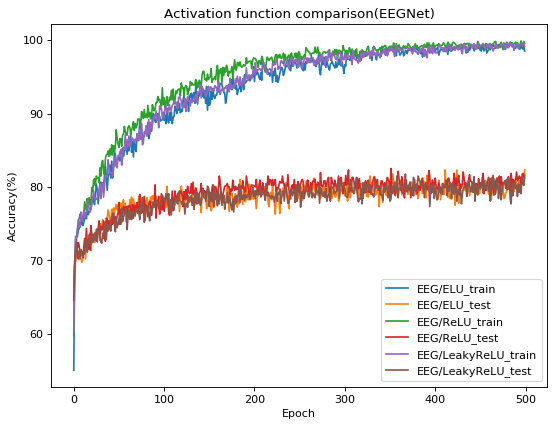

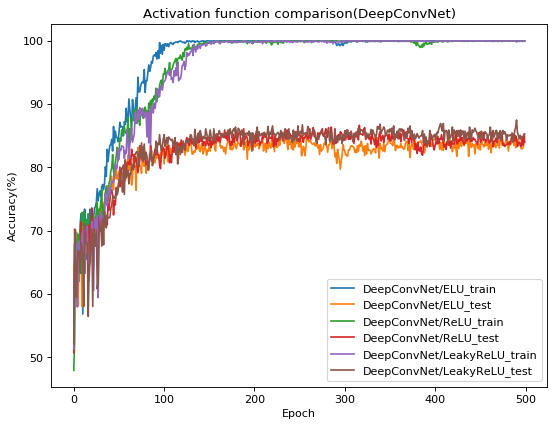

In [12]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title("Activation function comparison(EEGNet)")
plt.ylabel("Accuracy(%)")
plt.xlabel("Epoch")
for i in range(3):
    plt.plot(train_accs[i], label=models[i][1]+"_train")
    plt.plot(test_accs[i], label=models[i][1]+"_test")
plt.legend(loc='lower right')
    
plt.figure(figsize=(8, 6), dpi=80)
plt.title("Activation function comparison(DeepConvNet)")
plt.ylabel("Accuracy(%)")
plt.xlabel("Epoch")
for i in range(3,6):
    plt.plot(train_accs[i], label=models[i][1]+"_train")
    plt.plot(test_accs[i], label=models[i][1]+"_test")
plt.legend(loc='lower right')
plt.show()

In [13]:
for index, test in enumerate(test_accs):
    print(models[index][1],max(test))

EEG/ELU 82.31481481481481
EEG/ReLU 82.5
EEG/LeakyReLU 81.75925925925925
DeepConvNet/ELU 85.64814814814815
DeepConvNet/ReLU 86.66666666666667
DeepConvNet/LeakyReLU 87.5
